# Differential abundance analysis

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import re
import warnings

import numpy as np
import protvi.plots as pl
import scanpy as sc
import scvi
from protvi.model import PROTVI

#warnings.filterwarnings("ignore")

scvi.settings.seed = 0

Seed set to 0


In [3]:
adata = sc.read("../../data/processed/leduc2022_pSCoPE_proteins_norm2.h5ad")
adata.layers["raw"] = adata.X.copy()

adata.obs.columns = [re.sub(r"(?<!^)(?=[A-Z])", "_", column).lower() for column in adata.obs.columns]
adata.var.columns = [re.sub(r"(?<!^)(?=[A-Z])", "_", column).lower() for column in adata.var.columns]

adata.obs["file_id"] = adata.obs["set"].values

In [4]:
adata

AnnData object with n_obs × n_vars = 1543 × 2844
    obs: 'set', 'channel', 'sample_annotation', 'sample_type', 'lcbatch', 'sortday', 'digest', 'melanoma_sub_cluster', 'file_id'
    var: 'leading.razor.protein', 'leading.razor.protein.id', 'leading.razor.protein.symbol'
    uns: 'X_name'
    layers: 'raw'

In [5]:
adata.X = adata.layers["raw"].copy()
adata.X[np.isnan(adata.X)] = 0
adata.X += 1

In [6]:
min_cells = int(adata.shape[0] * 0.05)
sc.pp.filter_genes(adata, min_cells=min_cells)

In [7]:
adata

AnnData object with n_obs × n_vars = 1543 × 2844
    obs: 'set', 'channel', 'sample_annotation', 'sample_type', 'lcbatch', 'sortday', 'digest', 'melanoma_sub_cluster', 'file_id'
    var: 'leading.razor.protein', 'leading.razor.protein.id', 'leading.razor.protein.symbol', 'n_cells'
    uns: 'X_name'
    layers: 'raw'

In [8]:
PROTVI.setup_anndata(adata, batch_key="file_id", categorical_covariate_keys=["channel"])

model = PROTVI(
    adata,
    log_variational=False,
    n_hidden=32,
    n_layers=1,
    decoder_type="selection",
)

/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.10/site-packages/scvi/data/fields/_dataframe_field.py:183: UserWarning: Category 44 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.10/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


In [9]:
model.train(max_epochs=3000, plan_kwargs={"mechanism_weight": 0, "kl_weight": 1}, check_val_every_n_epoch=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 3000/3000: 100%|██████████| 3000/3000 [10:43<00:00,  4.39it/s, v_num=1, train_loss_step=565, train_loss_epoch=556]    

`Trainer.fit` stopped: `max_epochs=3000` reached.


Epoch 3000/3000: 100%|██████████| 3000/3000 [10:43<00:00,  4.66it/s, v_num=1, train_loss_step=565, train_loss_epoch=556]


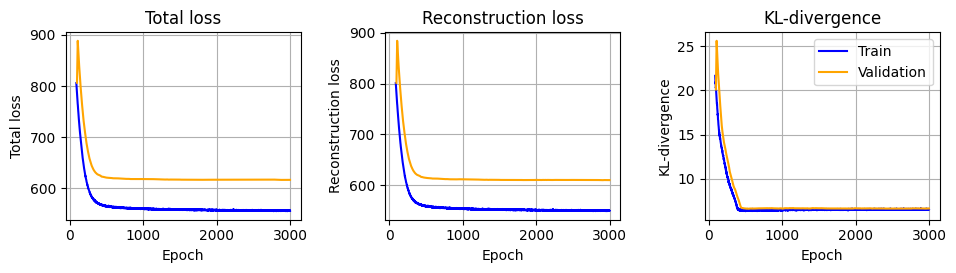

In [10]:
pl.plot_loss(model.history, epoch_start=90, validation_smooth_window=10)

In [11]:
model.save("leduc2022_pSCoPE_model")

In [ ]:
model = PROTVI.load("leduc2022_pSCoPE_model", adata)

In [10]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

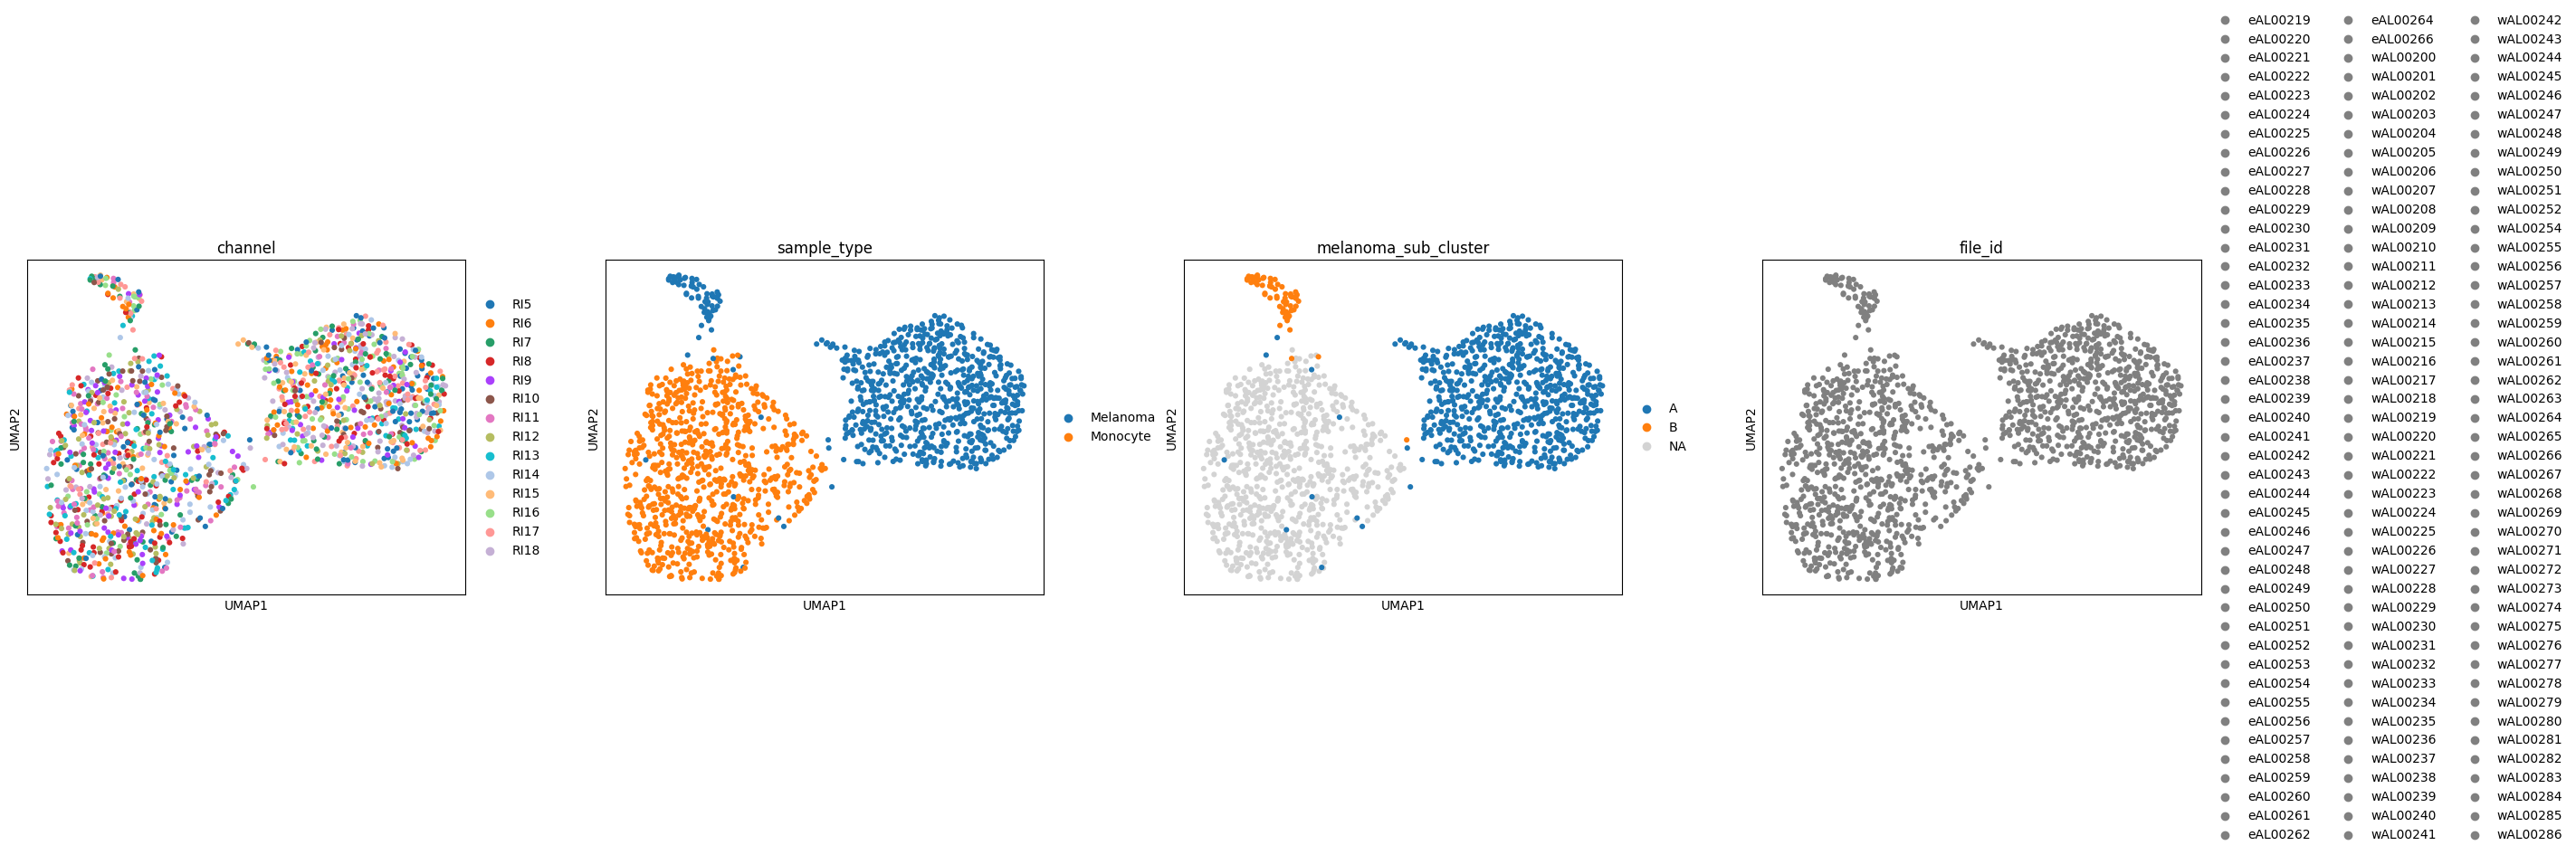

In [19]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color=["channel", "sample_type", "melanoma_sub_cluster", "file_id"],
    vmin="p01",
    vmax="p99",
    ncols=4,
    wspace=0.2,
)

In [10]:
idx1 = np.where(adata.obs["sample_type"] == "Melanoma")[0]
idx2 = np.where(adata.obs["sample_type"] == "Monocyte")[0]

In [20]:
x_norm = model.get_normalized_abundance(indices=idx1, return_numpy=True)

In [11]:
da = model.differential_abundance(groupby="sample_type", batch_correction=True)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.10/site-packages/scvi/data/fields/_dataframe_field.py:221: UserWarning: Category 44 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(


DE...:   0%|          | 0/2 [00:00<?, ?it/s]

/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.10/site-packages/scvi/model/base/_differential.py:307: RuntimeWarning: invalid value encountered in log2
  return np.log2(x + pseudocounts) - np.log2(y + pseudocounts)
/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.10/site-packages/scvi/model/base/_differential.py:307: RuntimeWarning: divide by zero encountered in log2
  return np.log2(x + pseudocounts) - np.log2(y + pseudocounts)


DE...:  50%|█████     | 1/2 [00:04<00:04,  4.57s/it]

/home/rasmus/rmls/work/ra/MS_mv_modelling/.conda/lib/python3.10/site-packages/scvi/model/base/_differential.py:307: RuntimeWarning: invalid value encountered in log2
  return np.log2(x + pseudocounts) - np.log2(y + pseudocounts)


DE...: 100%|██████████| 2/2 [00:10<00:00,  5.12s/it]


In [12]:
da

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,emp_mean1,emp_mean2,emp_effect,is_de_fdr_0.05,comparison,group1,group2
A6NFQ2,0.818591,0.181409,1.506833,0.552034,0.544123,0.0,0.25,NaN,NaN,NaN,NaN,NaN,1.000000,0.998710,0.001290,False,Melanoma vs Rest,Melanoma,Rest
Q27J81,0.816544,0.183456,1.493105,0.593847,0.591261,0.0,0.25,NaN,NaN,NaN,NaN,NaN,0.997396,0.998710,-0.001314,False,Melanoma vs Rest,Melanoma,Rest
Q9Y383,0.815315,0.184685,1.484925,0.645957,0.648115,0.0,0.25,NaN,NaN,NaN,NaN,NaN,0.994792,0.966452,0.028340,False,Melanoma vs Rest,Melanoma,Rest
Q86WT6,0.814906,0.185094,1.482208,0.605661,0.593536,0.0,0.25,NaN,NaN,NaN,NaN,NaN,0.997396,0.996129,0.001267,False,Melanoma vs Rest,Melanoma,Rest
P09104,0.813677,0.186323,1.474084,0.763661,0.758351,0.0,0.25,NaN,NaN,NaN,NaN,NaN,0.983073,0.889032,0.094041,False,Melanoma vs Rest,Melanoma,Rest
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y5H5,0.000000,1.000000,-18.420681,-0.505536,-0.515828,0.0,0.25,NaN,NaN,NaN,NaN,NaN,1.000000,0.998698,0.001302,False,Monocyte vs Rest,Monocyte,Rest
Q8IZU8,0.000000,1.000000,-18.420681,-0.666169,-0.668192,0.0,0.25,NaN,NaN,NaN,NaN,NaN,0.998710,0.998698,0.000012,False,Monocyte vs Rest,Monocyte,Rest
P23193,0.000000,1.000000,-18.420681,-0.683659,-0.685234,0.0,0.25,NaN,NaN,NaN,NaN,NaN,0.967742,0.967448,0.000294,False,Monocyte vs Rest,Monocyte,Rest
O00400,0.000000,1.000000,-18.420681,-0.787708,-0.787488,0.0,0.25,NaN,NaN,NaN,NaN,NaN,0.990968,0.990885,0.000082,False,Monocyte vs Rest,Monocyte,Rest
